# Behavioral Cloning

### Behavioral Cloning Project

The goals / steps of this project are the following:

*    Use the simulator to collect data of good driving behavior
*    Build, a convolution neural network in Keras that predicts steering angles from images
*    Train and validate the model with a training and validation set
*    Test that the model successfully drives around track one without leaving the road
*    Summarize the results with a written report

### Files Submitted & Code Quality
#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

#### My project includes the following files:

* `3_Asigment.ipynb` containing the script to create and train the model
* `drive.py` for driving the car in autonomous mode
* `model_2_.h5` containing a trained convolution neural network 
* `writeup_report.md` summarizing the results
* `video.mp4` a sample video of the given track with autonomous drive

#### 2. Submission includes functional code

Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing

* `python drive.py model_2_.h5`

#### 3. Model parameter tuning

For the parameter tunning the model uses the AdamOptimizer.

#### 4. Appropriate training data

To create the training data I used the training data given by Udacity. I also tried to drive the track one with good behavior one time forward and once backward. The same procedure was done on the track 2.

#### 1. Solution Design Approach

The overall strategy for deriving a model architecture was to ...

My strategy was to use my own data set. At first I collect my data set with the help of the udacity simulator. I ran each track twice in one way and twice in opposite way. The usage of flip technik was not realy helpfull for me.

I use a convolution neural network model similar from the [Nvidia Paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. I also crop my image to reduce amount of data feeding into RAM.


The final step was to run the simulator to see how well the car was driving around track one. There was one spot where the vehicle fell off the track at the second track I think I should play around with corresction factors. Another way can be so use udacity data set and just add my trimed data set in to it.

At the end of the process, the vehicle is able to drive autonomously around the first track without leaving the road.

#### 2. Nvidia Model Architecture

Here is a visualization of the architecture which based on this paper [Nvidia Paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).
I crop my images by 50 upper side and 20 from down side of each image. I also use batch normalization between the layers to keep the mean activation near zero. To avoid overfitting I use drop outs flatted fully connected layers. The model used an adam optimizer, so the learning rate was not tuned manually. I used “exponential linear unit” (ELU) which speeds up learning indeep neural networks and leads to higher classification accuracies




|Layer (type)                 | Output Shape             | Param #  |
|-----------------------------|--------------------------|----------|
|cropping2d_1 (Cropping2D)    |(None, 90, 320, 3)        |0         |        
|lambda_1 (Lambda)            |(None, 90, 320, 3)        |0         |
|batch_normalization_1 (Batch |(None, 90, 320, 3)        |12        |
|conv2d_1 (Conv2D)            |(None, 43, 158, 24)       |1824      |
|conv2d_2 (Conv2D)            |(None, 20, 77, 36)        |21636     |
|conv2d_3 (Conv2D)            |(None, 8, 37, 48)         |43248     |
|batch_normalization_2 (Batch |(None, 8, 37, 48)         |192       |
|conv2d_4 (Conv2D)            |(None, 6, 35, 64)         |27712     |
|conv2d_5 (Conv2D)            |(None, 4, 33, 64)         |36928     |
|dropout_1 (Dropout)          |(None, 4, 33, 64)         |0         |
|flatten_1 (Flatten)          |(None, 8448)              |0         |
|dense_1 (Dense)              |(None, 100)               |844900    |
|batch_normalization_3 (Batch |(None, 100)               |400       |
|dropout_2 (Dropout)          |(None, 100)               |0         |
|dense_2 (Dense)              |(None, 50)                |5050      |
|batch_normalization_4 (Batch |(None, 50)                |200       |
|dropout_3 (Dropout)          |(None, 50)                |0         |
|dense_3 (Dense)              |(None, 10)                |510       |
|batch_normalization_5 (Batch |(None, 10)                |40        |
|dense_4 (Dense)              |(None, 1)                 |11        |

Total params: 982,663
Trainable params: 982,241
Non-trainable params: 422


#### 3. Model parameter tuning

*    The model used an adam optimizer, so the learning rate was not tuned manually.
*    I kept the batch size 32
*    correction factor= 0.2 for adjust left and right camera images
     and ran the model for 12 epochs to make model.py but here just 5 epoch


#### 4. Appropriate training data
I collect my data with Udacity Simulator. I drove each track twice in one way and twice in opposite way. The usage of flip technik was not realy helpfull for me.

#### Summary

To my understanding the way that data set is prepaired play a big role how it will work on autonomous mode. The amount of data set also play a role. As I had no cuda graphic card and the training is very time costly, I could not play more with all ideas which to make my model work better on the second track. By the way it acts quite good up to last slope! :).

In [1]:
# Import libraries

from keras.models import Sequential, Model
from keras.layers import Lambda, Cropping2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

import cv2
import numpy as np
import matplotlib.pyplot as plt

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import csv

from PIL import Image

import math

Using TensorFlow backend.


In [2]:
# set the path
def load_files(base_path, csv_name = "driving_log.csv", correction = 0.2, image_samples=[]):

# set the paths of CSV file and where the Images files are    
    csv_path= str(base_path) + str(csv_name)
    image_Path = str(base_path) + "IMG/"
    drop_prob = 0.8
# open and read each line of CSV file in order to find the specific values for:
# center line[0], left line[1] and right camera line[2]   
    with open(csv_path) as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
# read out where steering data is stored line[3]            
            steering_angle = float(line[3])
            for i in range(3):
# put each path in file name and image file path             
                image_file_name = get_file_field(line[i])
                image_file_path = str(image_Path) + str(image_file_name)
                
# randomly droping steering zero with probability of 0.8 which means only 20 % of the time 
# images of car riding strait a head streeing zero is put in to data set
                if steering_angle == 0 and np.random.rand() < drop_prob:
                    continue 
# Initialinf the data with file path            
                data = [image_file_path]
# appending steering data with the correcction fo each side cameras to the data                
                if i == 0:
                    data.append(steering_angle) # center camera
                if i == 1:
                    data.append(steering_angle + correction) # left camera
                if i == 2:
                    data.append(steering_angle - correction) # right camera
                    
                image_samples.append(data)   
    return image_samples

In [3]:
# split the path and use the name only part
def get_file_field(place_holder=""):
    
    return place_holder.split('/')[-1]

In [4]:
# using generator help out with memory shortage at raining later on
# here we manage x_train and y_train data for the training
def generator(samples, batch_size=32):
    num_samples = len(samples)

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
# where the Images are actually are                
                name = '/home/kayvan/Documents/Udacity/3_Asignment/Training_Files/IMG/'+batch_sample[0].split('/')[-1]
# reading each image convert them for X input data and Y (labels)                  
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image,cv2.COLOR_BGR2RGB)
        
                center_angle = float(batch_sample[1])
                
                images.append(center_image)
                angles.append(center_angle)                
# I used them once but the results was not so good but I kep them here to know later 
# how can I use some modification to increase data base on small recording dataset

                #image_flipped = np.fliplr(center_image)
                #center_angle_flipped = - center_angle
                #images.append(image_flipped)
                #angles.append(center_angle_flipped)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [5]:
# where all my samples are
samples = load_files('/home/kayvan/Documents/Udacity/3_Asignment/Training_Files/')

In [6]:
# split the data to into train_samples, validation_samples
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Training Samples:', len(train_samples))
print('Validation Samples: ', len(validation_samples))

# compile and train the model using the generator function
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

Training Samples: 11782
Validation Samples:  2946


In [7]:
# Model NVIDIA

def Nvidia_model(drop_rate=0.5, input_shape=(160, 320, 3)):
    
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 127.5) - 1.))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Dropout(drop_rate))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Dense(50, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))    
    model.add(Dense(10, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [8]:
# Add the model data and fitting
model = Nvidia_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 320, 3)        12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 37, 48)         192       
__________

In [9]:
# Training 
# for the training I run with 15 epochs but here I'll go just 5 epochs to generate the plot later on

batch_size = 32

history_object = model.fit_generator(train_generator, 
            steps_per_epoch=int(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=int(len(validation_samples)/batch_size), 
            epochs=5, verbose=1)

Epoch 1/5
368/368 [==============================] - 377s 1s/step - loss: 0.3109 - val_loss: 0.1104
Epoch 2/5
368/368 [==============================] - 340s 925ms/step - loss: 0.1374 - val_loss: 0.0990
Epoch 3/5
368/368 [==============================] - 347s 944ms/step - loss: 0.1168 - val_loss: 0.0948
Epoch 4/5
368/368 [==============================] - 355s 965ms/step - loss: 0.1085 - val_loss: 0.0843
Epoch 5/5
368/368 [==============================] - 365s 993ms/step - loss: 0.1031 - val_loss: 0.0845


In [10]:
model.save('model_2_.h5')

dict_keys(['val_loss', 'loss'])


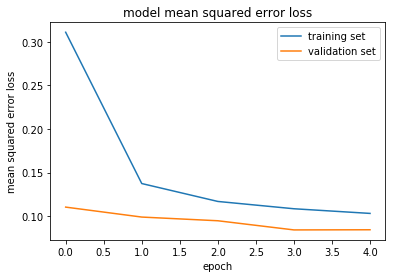

In [11]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()